### Preprocessing

In [1]:
import sys 
import os
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from pathlib import Path
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

import cdt
cdt.SETTINGS.rpath = "/usr/bin/Rscript"
from cdt.causality.graph import PC, GES

import pandas as pd
from src.features import preprocessing
import numpy as np
import networkx as nx
import time
import datetime

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [2]:
data_path = Path('/home/ralmasri/projects/Thesis/Domain-Guided-Monitoring/data/')
csv_path = data_path / "logs_aggregated_concurrent.csv"
huawei_config = preprocessing.HuaweiPreprocessorConfig()
huawei_config.aggregated_log_file = csv_path
preprocessor = preprocessing.ConcurrentAggregatedLogsPreprocessor(huawei_config)
# huawei_df = preprocessor._load_log_only_data().fillna("")
huawei_df = pd.read_csv(data_path / "log_only_data.csv").fillna("").astype(str)

In [3]:
df_sizes = [100, 1000]
huawei_dfs = [huawei_df.head(x) for x in df_sizes]
results = {}

In [4]:
def convert_causality_records_to_graph(causality_record):
    vocab = {}
    index =  0
    df = pd.DataFrame.from_records(causality_record).drop_duplicates().reset_index(drop=True)
    df.drop(labels=[x for x in df.columns if x not in ['parent_id', 'child_id']], axis=1, inplace=True)
    nodes = []
    edges = []
    for _, row in df.iterrows():
        parent, child = row['parent_id'], row['child_id']
        if parent not in vocab:
            vocab[parent] = index
            parent_type, parent_value = tuple(parent.split('#'))
            nodes.append((index, {'value': parent_value, 'type': parent_type}))
            index += 1
        if child not in vocab:
            vocab[child] = index
            child_type, child_value = tuple(child.split('#'))
            nodes.append((index, {'value': child_value, 'type': child_type}))
            index += 1
        edges.append((vocab[parent], vocab[child]))
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    return G

In [5]:
CDT_ALGORITHMS = {
    'constraint': lambda df: PC(CItest = 'binary').predict(df),
    'score': lambda df: GES().predict(df),
}

### Transformation without filtering

In [6]:
from collections import namedtuple
EvDef = namedtuple('EvDef', ['type', 'value'])
class EventDefinitionMap: # eid -> evdef
    def __init__(self, top_dt, end_dt):
        self.top_dt = top_dt
        self.end_dt = end_dt
        self._emap = {} # key : eid, val : evdef
        self._ermap = {} # key : evdef, val : eid

    def __len__(self):
        return len(self._emap)

    def _eids(self):
        return self._emap.keys()

    def _next_eid(self):
        eid = len(self._emap)
        while eid in self._emap:
            eid += 1
        else:
            return eid

    def get_evdef(self, eid) -> EvDef:
        return self._emap[eid]

    def get_eid(self, evdef):
        return self._ermap[evdef]

    def process_row(self, columns, row):
        row_eids = []
        for column in columns:
                if column == '@timestamp':
                    continue
                value = row[column]
                if value == "":
                    continue
                d = {
                    "type": column,
                    "value": row[column],
                }

                evdef = EvDef(**d)

                if evdef in self._ermap:
                    row_eids.append(self._ermap[evdef])
                else:
                    eid = self._next_eid()
                    self._emap[eid] = evdef
                    self._ermap[evdef] = eid
                    row_eids.append(eid)
        return row_eids

In [7]:
def label(dt_range, duration):
    top_dt, end_dt = dt_range
    l_label = []
    temp_dt = top_dt
    while temp_dt < end_dt:
        l_label.append(temp_dt)
        temp_dt += duration
    l_label.append(end_dt)
    return l_label

In [8]:
def discretize(l_dt, l_label, method):

    def return_empty(size):
        if method in ("count", "binary"):
            return [0] * bin_num
        elif method == "datetime":
            return [[] for i in range(bin_num)]
        else:
            raise NotImplementedError(
                "Invalid method name ({0})".format(method))

    def init_tempobj():
        if method == "count":
            return 0
        elif method == "binary":
            return 0
        elif method == "datetime":
            return []
        else:
            raise NotImplementedError(
                "Invalid method name ({0})".format(method))

    def update_tempobj():
        if method == "count":
            return temp + 1
        elif method == "binary":
            return 1
        elif method == "datetime":
            temp.append(new_dt)
            return temp
        else:
            raise NotImplementedError(
                "Invalid method name ({0})".format(method))

    bin_num = len(l_label) - 1
    l_dt_temp = sorted(l_dt)
    if len(l_dt_temp) <= 0:
        return_empty(bin_num)

    iterobj = iter(l_dt_temp)
    try:
        new_dt = next(iterobj)
    except StopIteration:
        raise ValueError("Not empty list, but failed to get initial value")
    while new_dt < l_label[0]:
        try:
            new_dt = next(iterobj)
        except StopIteration:
            return_empty(bin_num)

    ret = []
    stop = False
    for label_dt in l_label[1:]:
        temp = init_tempobj()
        if stop:
            ret.append(temp)
            continue
        while new_dt < label_dt:
            temp = update_tempobj()
            try:
                new_dt = next(iterobj)
            except StopIteration:
                # "stop" make data after label term be ignored
                stop = True
                break
        ret.append(temp)
    return ret

def autodiscretize_with_slide(l_dt, binsize, slide, dt_range):
    top_dt, end_dt = dt_range
    slide_width = max(int(binsize.total_seconds() / slide.total_seconds()), 1)
    l_top = label((top_dt, end_dt), slide)[:-1]
    l_end = [min(t + binsize, end_dt) for t in l_top]

    ret = []
    noslide = discretize(l_dt, l_top + [end_dt], method='datetime')
    for i, bin_end in enumerate(l_end):
        l_dt_temp = []
        for b in noslide[i:i+slide_width]:
            l_dt_temp.extend([dt for dt in b if dt <= bin_end])
    
        if len(l_dt_temp) > 0:
            ret.append(1)
        else:
            ret.append(0)

    return ret

    

In [9]:
# Assume we're using the G-squared test so everything is binary
def event2stat(evdict, top_dt, end_dt, dur, bin_overlap):
    """This function looks at each event and returns a map that maps the 
    eid to a list that describes in which time bins the event occurs"""
    d_stat = {}
    labels = label((top_dt, end_dt), dur)
    for eid, l_ev in evdict.items():
        # if len(l_ev) == 0: # Skip events that dont have timestamps (shouldn't be possible)
        #     continue

        if bin_overlap == datetime.timedelta(seconds = 0):
            val = discretize(l_ev, labels, method="binary")
        else:
            slide = dur - bin_overlap
            val = autodiscretize_with_slide(l_ev, dur, slide, dt_range = (top_dt, end_dt))
        if val is not None:
            d_stat[eid] = val
    return d_stat

In [10]:
def create_maps(data_df: pd.DataFrame, top_dt: datetime.datetime, end_dt: datetime.datetime):
    def append_to_evdict(evdict, eid, val):
        if eid in evdict:
                evdict[eid].append(val)
        else:
            evdict[eid] = [val]

    evmap = EventDefinitionMap(top_dt=top_dt, end_dt=end_dt)
    evdict = {} # Event id -> list(datetime.datetime)
    for _, row in data_df.iterrows():
        row_eids = evmap.process_row(data_df.columns, row)
        timestamp = row['@timestamp']
        for eid in row_eids:
            if eid in evdict:
                evdict[eid].append(row['@timestamp'])
            else:
                evdict[eid] = [row['@timestamp']]            
    return evmap, evdict

def get_date_range(data_df):
    date_format = '%Y-%m-%dT%H:%M:%S.%f000%z'
    data_df['@timestamp'] = data_df['@timestamp'].apply(lambda x: datetime.datetime.strptime(x, date_format))
    min_dt = data_df['@timestamp'].iloc[0].to_pydatetime()
    max_dt = data_df['@timestamp'].iloc[-1].to_pydatetime()
    print(f"Min: {min_dt}")
    print(f"Max: {max_dt}")
    top_dt = datetime.datetime.combine(min_dt.date(), datetime.time(hour=min_dt.hour)).replace(tzinfo=min_dt.tzinfo)
    end_dt = datetime.datetime.combine(max_dt.date(), datetime.time(hour=max_dt.hour, minute=max_dt.minute + 1)).replace(tzinfo=min_dt.tzinfo)
    return top_dt, end_dt


def generate_transformation_knowledge(huawei_df: pd.DataFrame, relevant_columns, method='constraint'):
    start_time = time.time()
    data_df = huawei_df.copy(deep=True)
    data_df.drop(labels=[x for x in data_df.columns if  x != '@timestamp' and x not in relevant_columns], axis=1, inplace=True)
    data_df = data_df.sort_values(by='@timestamp').reset_index(drop=True).fillna("")
    top_dt, end_dt = get_date_range(data_df)
    dur = datetime.timedelta(seconds=10)
    bin_overlap = datetime.timedelta(seconds = 8)
    evmap, evdict = create_maps(data_df, top_dt, end_dt)
    data = event2stat(evdict, top_dt, end_dt, dur, bin_overlap)
    dm = np.array([d for eid, d in sorted(data.items())]).transpose()
    df = pd.DataFrame(dm)
    print(f"Preprocessing time in seconds: {time.time() - start_time}")
    output: nx.Graph = CDT_ALGORITHMS[method](df)
    print(f"Number of nodes (including non-connected nodes): {output.number_of_nodes()}")
    causality_records = []
    for edge in list(output.edges()): # list((eid, eid))
        from_eid, to_eid = edge[0], edge[1]
        from_evdef = evmap.get_evdef(from_eid)
        to_evdef = evmap.get_evdef(to_eid)
        causality_records.append(
            {
                "parent_id": from_evdef.type + '#' + str(from_evdef.value),
                "parent_name": from_evdef.value,
                "child_id": to_evdef.type + '#' + str(to_evdef.value),
                "child_name": to_evdef.value,
            }
        )
    graph = convert_causality_records_to_graph(causality_records)
    print(graph)
    return graph

In [11]:
def calculate_knowledge_for_huawei_dfs(huawei_dfs, method, results):
    results[f"fine_{method}"] = []
    results[f"coarse_{method}"] = []
    results[f"fine+coarse_{method}"] = []
    for i, huawei_df in enumerate(huawei_dfs):
        start = time.time()
        print(f"Calculating for size {df_sizes[i]}")
        results[f"fine_{method}"].append(generate_transformation_knowledge(huawei_df, ['fine_log_cluster_template'], method))
        results[f"coarse_{method}"].append(generate_transformation_knowledge(huawei_df, ['coarse_log_cluster_template'], method))
        results[f"fine+coarse_{method}"].append(generate_transformation_knowledge(huawei_df, ['fine_log_cluster_template', 'coarse_log_cluster_template'], method))
        print(f"Total processing time in seconds: {time.time() - start}")

print("Constraint-based:")
calculate_knowledge_for_huawei_dfs(huawei_dfs, 'constraint', results)
print('##################################################')
print("Score-based:")
calculate_knowledge_for_huawei_dfs(huawei_dfs, 'score', results)

Constraint-based:
Calculating for size 100
Min: 2019-11-19 17:00:05+01:00
Max: 2019-11-19 17:04:20.472000+01:00
Preprocessing time in seconds: 0.11542963981628418
Number of nodes (including non-connected nodes): 29
DiGraph with 14 nodes and 16 edges
Min: 2019-11-19 17:00:05+01:00
Max: 2019-11-19 17:04:20.472000+01:00
Preprocessing time in seconds: 0.07536101341247559
Number of nodes (including non-connected nodes): 18
DiGraph with 15 nodes and 18 edges
Min: 2019-11-19 17:00:05+01:00
Max: 2019-11-19 17:04:20.472000+01:00
Preprocessing time in seconds: 0.10883378982543945
Number of nodes (including non-connected nodes): 47
DiGraph with 28 nodes and 30 edges
Total processing time in seconds: 29.864840745925903
Calculating for size 1000
Min: 2019-11-19 17:00:05+01:00
Max: 2019-11-19 17:17:31.496000+01:00
Preprocessing time in seconds: 0.6656174659729004
Number of nodes (including non-connected nodes): 69
DiGraph with 60 nodes and 98 edges
Min: 2019-11-19 17:00:05+01:00
Max: 2019-11-19 17:1

### My method

In [12]:
def generate_my_method_knoweldge(huawei_df, method, relevant_columns):
    start_time = time.time()
    vocab = set()
    for _, row in huawei_df.iterrows():
        for column in relevant_columns:
            if column == '@timestamp':
                continue
            name = column + "#" + str(row[column]).lower()
            if name not in vocab and row[column] != "":
                vocab.add(name)
    df_dict = {}
    for column in vocab:
        attribute, value = tuple(column.split('#'))
        if column not in df_dict:
            df_dict[column] = huawei_df[attribute].apply(lambda x: 1 if x == value else 0)
        else:
            df_dict[column] |= huawei_df[attribute].apply(lambda x: 1 if x == value else 0)
    alg_df = pd.concat(df_dict, axis=1)
    print(f"Preprocessing time in seconds: {time.time() - start_time}")
    output: nx.Graph = CDT_ALGORITHMS[method](alg_df)
    print(f"Number of nodes (including non-connected nodes): {output.number_of_nodes()}")
    causality_records = []
    for edge in list(output.edges()):
        from_value, to_value = edge
        causality_records.append(
            {
                "parent_id": from_value,
                "parent_name": from_value.split("#")[1],
                "child_id": to_value,
                "child_name": to_value.split("#")[1],
            },
        )
    
    graph = convert_causality_records_to_graph(causality_records)
    print(graph)
    return graph

In [13]:

def calculate_knowledge_for_huawei_dfs_my_method(huawei_dfs, method, results):
    results[f"mm_fine_{method}"] = []
    results[f"mm_coarse_{method}"] = []
    results[f"mm_fine+coarse_{method}"] = []
    for i, huawei_df in enumerate(huawei_dfs):
        start = time.time()
        print(f"Calculating for size {df_sizes[i]}")
        results[f"mm_fine_{method}"].append(generate_my_method_knoweldge(huawei_df, method, ['fine_log_cluster_template']))
        results[f"mm_coarse_{method}"].append(generate_my_method_knoweldge(huawei_df, method, ['coarse_log_cluster_template']))
        results[f"mm_fine+coarse_{method}"].append(generate_my_method_knoweldge(huawei_df, method, ['fine_log_cluster_template', 'coarse_log_cluster_template']))
        print(f"Total processing time in seconds: {time.time() - start}")

print("Constraint-based:")
calculate_knowledge_for_huawei_dfs_my_method(huawei_dfs, 'constraint', results)
print('##################################################')
print("Score-based:")
calculate_knowledge_for_huawei_dfs_my_method(huawei_dfs, 'score', results)

Constraint-based:
Calculating for size 100
Preprocessing time in seconds: 0.08612990379333496
Number of nodes (including non-connected nodes): 29
DiGraph with 0 nodes and 0 edges
Preprocessing time in seconds: 0.05471229553222656
Number of nodes (including non-connected nodes): 18
DiGraph with 2 nodes and 2 edges
Preprocessing time in seconds: 0.06391286849975586
Number of nodes (including non-connected nodes): 47
DiGraph with 38 nodes and 40 edges
Total processing time in seconds: 25.698364973068237
Calculating for size 1000
Preprocessing time in seconds: 0.41600656509399414
Number of nodes (including non-connected nodes): 69
DiGraph with 6 nodes and 24 edges
Preprocessing time in seconds: 0.2943089008331299
Number of nodes (including non-connected nodes): 18
DiGraph with 7 nodes and 31 edges
Preprocessing time in seconds: 0.46739864349365234
Number of nodes (including non-connected nodes): 87
DiGraph with 37 nodes and 36 edges
Total processing time in seconds: 72.82306480407715
#####

### Drawings

In [14]:
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, show

COLOR_MAP = {
    'Hostname': '#FF0000', # red
    'log_level': '#0000FF', # blue
    'programname': '#00FF00', # green
    'python_module': '#FFFF00', # yellow
    'http_status': '#FFA500', # orange
    'http_method': '#FFC0CB', # pink
    'fine_log_cluster_template': '#A020F0', # purple
    'coarse_log_cluster_template': '#808080', # grey
    'url_cluster_template': '#964B00' # brown
}

def get_color_map(G: nx.Graph):
    return [COLOR_MAP[node[1]['type']] for node in G.nodes(data=True)]

def node_to_color(node):
    return COLOR_MAP[node[1]['type']]

In [15]:
output_notebook() # allows bokeh visualizations to be shown in the notebook

Loading BokehJS ...

In [16]:
for G_list in results.values():
    for G in G_list:
        for node in G.nodes(data=True):
            node[1]['color'] = node_to_color(node)

In [17]:
from bokeh.plotting import figure, from_networkx
from bokeh.models import Circle, MultiLine, NodesAndLinkedEdges, EdgesAndLinkedNodes


def create_plot(title, G, pos):
    #Establish which categories will appear when hovering over each node
    HOVER_TOOLTIPS = [("Index", "@index"), ("Type", "@type"), ("Value", "@value")]

    #Create a plot — set dimensions, toolbar, and title
    plot = figure(tooltips = HOVER_TOOLTIPS, tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',title=title)

    #Create a network graph object with spring layout
    # https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
    network_graph = from_networkx(G, pos, scale=10, center=(0, 0))

    #Set node size and color
    network_graph.node_renderer.glyph = Circle(size=15, fill_color='color')

    #Set edge opacity and width
    network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

    #Add network graph to the plot
    plot.renderers.append(network_graph)

    return plot

def plot_graph(G, title):
    plt.figure(figsize=(10, 10), dpi=80)
    pos =  nx.nx_agraph.graphviz_layout(G)
    nx.draw_networkx(G, with_labels=True, pos=pos, node_color=get_color_map(G))
    plot = create_plot(title, G, pos)
    show(plot)

#### Score 

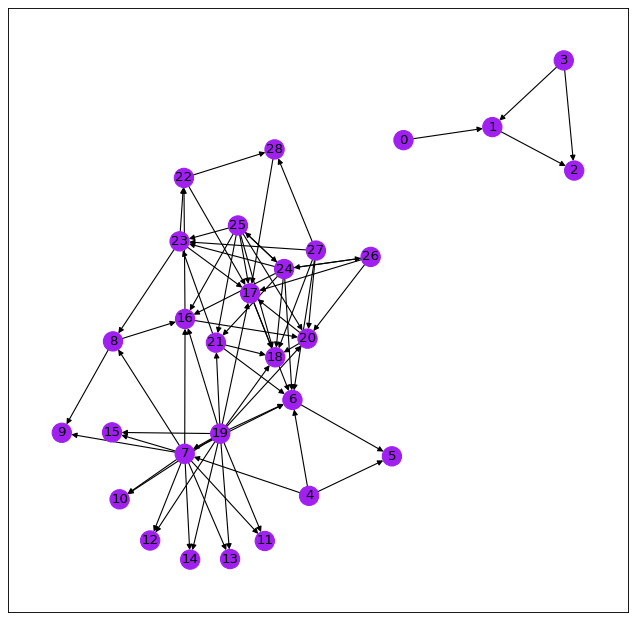

In [18]:
G = results['fine_score'][0]
plot_graph(G, 'Fine log templates from 100 data entries with score algorithm')

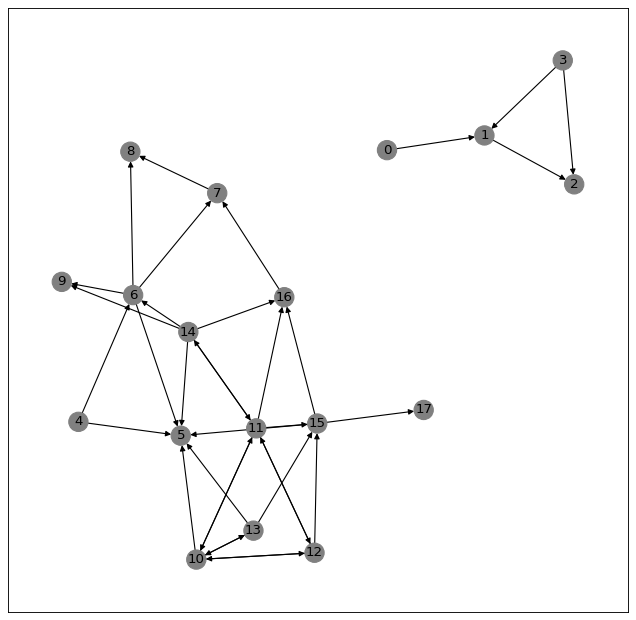

In [19]:
G = results['coarse_score'][0]
plot_graph(G, 'Coarse log templates from 100 data entries with score algorithm')

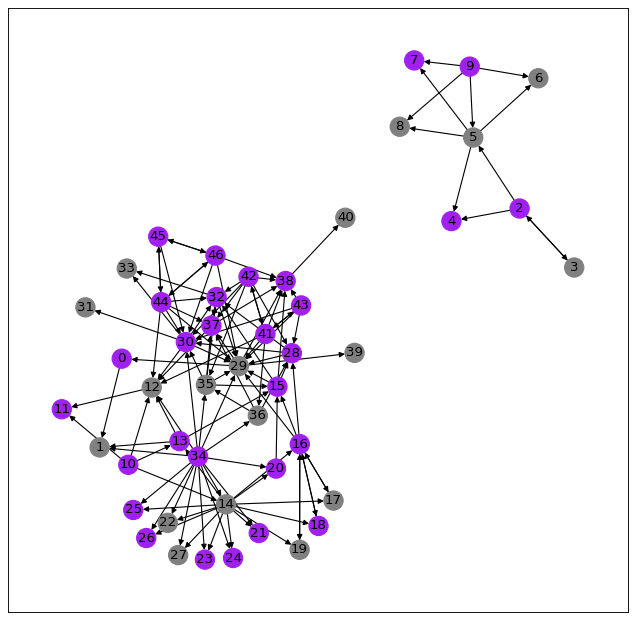

In [20]:
G = results['fine+coarse_score'][0]
plot_graph(G, 'Fine and coarse log templates from 100 data entries with score algorithm')

#### Constraint

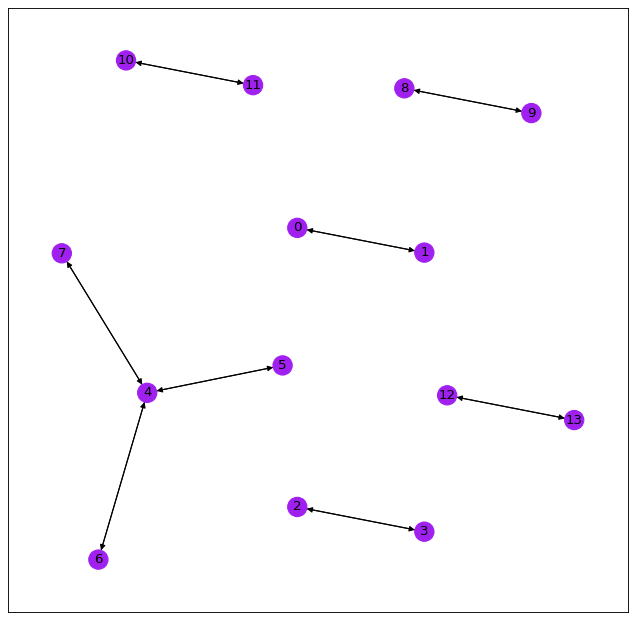

In [21]:
G = results['fine_constraint'][0]
plot_graph(G, 'Fine log templates from 100 data entries with constraint algorithm')

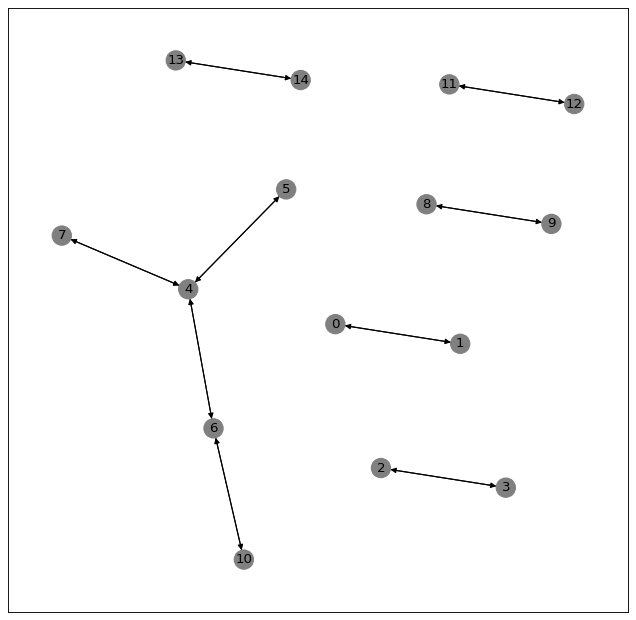

In [22]:
G = results['coarse_constraint'][0]
plot_graph(G, 'Coarse log templates from 100 data entries with constraint algorithm')

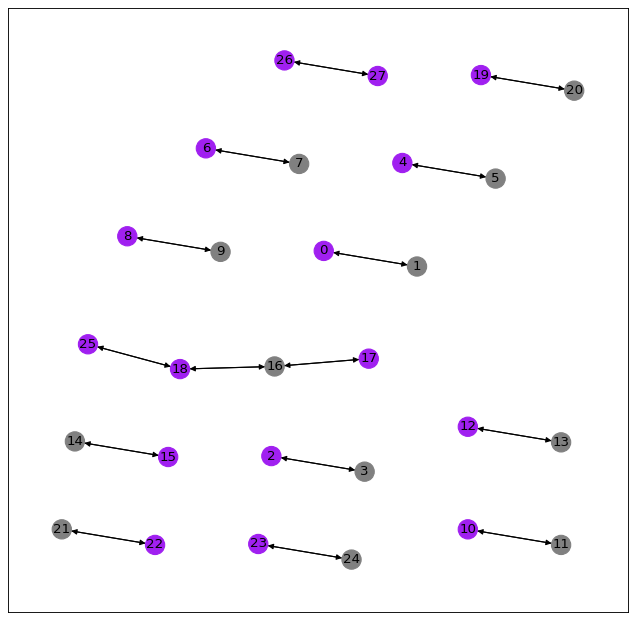

In [23]:
G = results['fine+coarse_constraint'][0]
plot_graph(G, 'Fine and coarse log templates from 100 data entries with constraint algorithm')